To Do:
- [x] Train random forest model on current dataset
- [x] Random generate localities of a given window size and activation threshold
- [x] Compute features of generated localities
- [x] Predict the minimum dipole of a batch of generated localities, then sort
- [x] Look at elite results (top 10) by eye across windows, compute some comparative statistics
- [ ] Take elite results, further optimize by simulated annealing

In [1]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt

### Validating feature extraction

In [140]:
match3 = np.load("match_3.npy")

In [142]:
pd.DataFrame(match3)

,0,1,2,3,4,5
0,1700.0,100.0,964.0,63.0,48.0,0.002954
1,2100.0,100.0,1182.0,48.0,22.0,0.004266
2,3300.0,100.0,1843.0,68.0,59.0,0.015801
3,5300.0,300.0,2800.0,182.0,8.0,0.004834
4,7900.0,500.0,4164.0,284.0,40.0,0.000000
...,...,...,...,...,...,...
80,700.0,7900.0,366.0,4069.0,43.0,0.026355
81,900.0,7900.0,468.0,4087.0,14.0,0.008710
82,4900.0,7900.0,2497.0,4136.0,98.0,0.014241
83,5100.0,7900.0,2673.0,4092.0,23.0,0.002915


In [147]:
x, y = match3[:, :2][:, 0], match3[:, :2][:, 1]

In [ ]:
extract_features(centroid_x, centroid_y, 40, 1000, 200)

### Data Preprocessing

In [2]:
df = pd.read_csv("dfRandomVer1V4.csv")
subCols = ["density_1000","lap_1000","dipole"]
subColsTest = ["density_1000","grad_1000","dipole"]
dfSub = df[subCols]
dfSubTest = df[subColsTest]

In [54]:
df.head()

,coord_x,coord_y,coord_x.1,coord_y.1,skeleton_length,dipole,density_200,density_500,density_800,density_1000,...,lap_1200,lap_1500,lap_2000,count_200,count_500,count_800,count_1000,count_1200,count_1500,count_2000
0,300.0,3500.0,211.0,1798.0,14.0,0.008938,0.0,0.000000,0.000000e+00,3.183099e-07,...,-107.999998,-175.999998,-303.999997,0.0,0.0,0.0,1.0,1.0,1.0,6.0
1,500.0,1300.0,310.0,660.0,39.0,0.018261,0.0,0.000001,4.973592e-07,3.183099e-07,...,-107.999993,-175.999992,-303.999990,0.0,1.0,1.0,1.0,2.0,3.0,8.0
2,700.0,6500.0,381.0,3345.0,31.0,0.028706,0.0,0.000000,0.000000e+00,3.183099e-07,...,-107.999998,-175.999995,-303.999994,0.0,0.0,0.0,1.0,2.0,8.0,11.0
3,700.0,7900.0,366.0,4069.0,43.0,0.014058,0.0,0.000001,4.973592e-07,3.183099e-07,...,-107.999975,-175.999974,-303.999974,0.0,1.0,1.0,1.0,1.0,2.0,5.0
4,900.0,1300.0,522.0,644.0,79.0,0.090741,0.0,0.000001,9.947184e-07,6.366198e-07,...,-107.999989,-175.999988,-303.999987,0.0,1.0,2.0,2.0,4.0,7.0,10.0


In [18]:
dfSub.head()

,density_1000,lap_1000,dipole
0,3.183099e-07,-67.999998,0.008938
1,3.183099e-07,-67.999994,0.018261
2,3.183099e-07,-67.999999,0.028706
3,3.183099e-07,-67.999975,0.014058
4,6.366198e-07,-67.999991,0.090741


In [104]:
dfSubTest

,density_1000,grad_1000,dipole
0,3.183099e-07,60.352647,0.008938
1,3.183099e-07,60.352643,0.018261
2,3.183099e-07,60.352646,0.028706
3,3.183099e-07,60.352630,0.014058
4,6.366198e-07,60.352641,0.090741
...,...,...,...
542,1.591549e-06,60.352637,0.018604
543,9.549297e-07,60.352639,0.008876
544,0.000000e+00,60.352648,0.027096
545,0.000000e+00,60.352648,0.184917


(array([ 57., 106., 131., 105.,  77.,  36.,  21.,   4.,   7.,   3.]),
 array([0.00000000e+00, 3.50140875e-07, 7.00281750e-07, 1.05042262e-06,
        1.40056350e-06, 1.75070437e-06, 2.10084525e-06, 2.45098612e-06,
        2.80112700e-06, 3.15126787e-06, 3.50140875e-06]),
 <BarContainer object of 10 artists>)

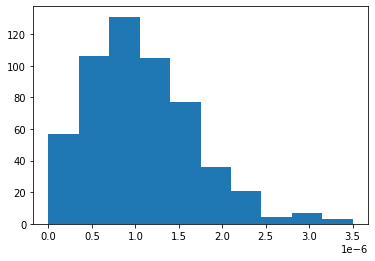

In [17]:
plt.hist(dfSub.density_1000)

(array([204., 146.,  58.,  71.,  37.,  13.,   7.,   7.,   2.,   2.]),
 array([-68.        , -67.99999154, -67.99998308, -67.99997462,
        -67.99996616, -67.9999577 , -67.99994924, -67.99994078,
        -67.99993232, -67.99992386, -67.9999154 ]),
 <BarContainer object of 10 artists>)

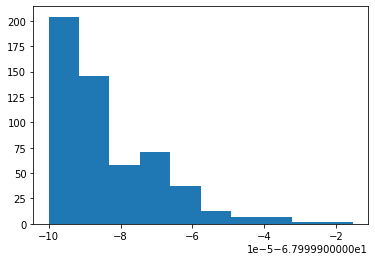

In [19]:
plt.hist(dfSub.lap_1000)

(array([372.,  93.,  29.,  27.,   9.,   4.,   7.,   3.,   2.,   1.]),
 array([0.        , 0.12185011, 0.24370022, 0.36555034, 0.48740045,
        0.60925056, 0.73110067, 0.85295078, 0.9748009 , 1.09665101,
        1.21850112]),
 <BarContainer object of 10 artists>)

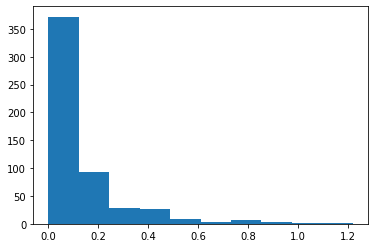

In [20]:
plt.hist(dfSub.iloc[:, -1])

### Function Definitions

 Models

In [15]:
def rf_model(df):
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    discriminator = RandomForestRegressor(max_depth=2)
    discriminator.fit(X, y)
    return discriminator

In [95]:
def linear_model(df):
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    discriminator = LinearRegression()
    discriminator.fit(X_scaled, y)
    return discriminator, scaler

In [100]:
hi, scaler = linear_model(dfSub)

In [101]:
hi.coef_

array([0.01717031, 0.08132392])

In [102]:
hi1, scaler = linear_model(dfSubTest)

In [103]:
hi1.coef_

array([ 0.01380557, -0.08119717])

Random generate localities of a given window size and activation threshold

In [5]:
def generate_pattern(pattern_dim, threshold):
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)
    
    org_locs = np.where(binary_pattern == 1)
    
    return org_locs[0], org_locs[1]#, binary_pattern

Compute features of generated localities

In [64]:
def extract_features(centroid_x, centroid_y, pattern_dim: int, local_radius: int, scale: int):
    pad = local_radius // scale + 1
    n=0

    cx_scaled = centroid_x + pad
    cy_scaled = centroid_y + pad

    mask_dim = pattern_dim + 2*pad
    mask = np.zeros((mask_dim, mask_dim))
    mask[cx_scaled, cy_scaled] = 1

    obj_exists = mask.flatten()

    coords = [i for i in range(0, mask_dim*scale, scale)]
    coords_scaled = np.array(list(product(coords, coords)))

    non_zero_coords = np.nonzero(obj_exists)

    non_zero_coords = coords_scaled[non_zero_coords]

    feats = []
    for coord in non_zero_coords:
        repeat = np.repeat([coord], len(coords_scaled), axis=0)
        diff = coords_scaled - repeat
        dists = np.sqrt(np.sum(diff**2, axis = 1))

        window_ids = np.argwhere((dists < local_radius) & (dists > 0))

        window_objs = obj_exists[window_ids]
        count = np.sum(window_objs)
        density = count/(np.pi*local_radius**2)

        window_dists = dists[window_ids]
        weights = (1/(window_dists**2))*window_objs - 1
        lap = np.sum(weights)

        diffs_window = diff[window_ids].squeeze()
        
        grad = weights*(diffs_window/window_dists)
        grad = np.sum(np.abs(grad), axis = 0)
        grad = np.sqrt(np.sum(grad**2))
        grad = np.around(grad, decimals = 10)

        feats.append([grad, density, lap])

    return non_zero_coords, np.array(feats)

### Predict the minimum dipole of a batch of generated localities, then sort

Using Density and Laplace features

In [65]:
pattern_dim = 5
threshold = 0.5
local_radius = 1000
scale = 200

Random Forest model discriminator

In [66]:
discriminator = rf_model(dfSub)

In [67]:
coords_predmin = []
for _ in tqdm(range(1000)):
    xs, ys = generate_pattern(pattern_dim, threshold)
    if len(xs) != 0:
        coords, feats = extract_features(xs, ys, pattern_dim, local_radius, scale)
        preds = discriminator.predict(scaler.transform(feats[:, 1:]))
        pattern_min = np.min(preds)
        pattern_mean = np.mean(preds)
        coords_predmin.append((coords, pattern_min, pattern_mean))


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 82.75it/s]


In [68]:
feats

array([[ 6.03525961e+01,  3.18309886e-06, -6.79999296e+01],
       [ 6.03525797e+01,  3.81971863e-06, -6.79999136e+01],
       [ 6.03525801e+01,  4.13802852e-06, -6.79999128e+01],
       [ 6.03525846e+01,  4.13802852e-06, -6.79999156e+01],
       [ 6.03526041e+01,  3.81971863e-06, -6.79999420e+01],
       [ 6.03525921e+01,  3.81971863e-06, -6.79999337e+01],
       [ 6.03525625e+01,  4.13802852e-06, -6.79998950e+01],
       [ 6.03525705e+01,  4.13802852e-06, -6.79999033e+01],
       [ 6.03526080e+01,  3.81971863e-06, -6.79999479e+01],
       [ 6.03525951e+01,  4.13802852e-06, -6.79999349e+01],
       [ 6.03525516e+01,  4.13802852e-06, -6.79998780e+01],
       [ 6.03525578e+01,  3.81971863e-06, -6.79998858e+01],
       [ 6.03525774e+01,  3.81971863e-06, -6.79999116e+01],
       [ 6.03525835e+01,  3.18309886e-06, -6.79999180e+01]])

Sort according to maximum minimum dipoles

In [69]:
localities_sorted = sorted(coords_predmin, key = lambda x: x[1], reverse = True)

In [70]:
# Look at elite results (top 10) by eye across windows, compute some comparative statistics

In [71]:
best_locals = localities_sorted[:10]

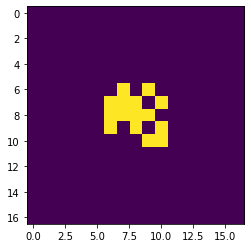

0.5452609388893618 0.5452609388893618


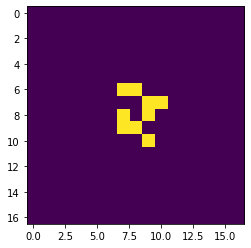

0.5452609388893618 0.5452609388893618


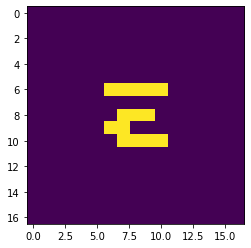

0.5452609388893618 0.5452609388893618


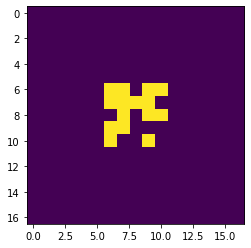

0.5452609388893618 0.5452609388893618


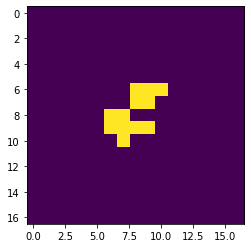

0.5452609388893618 0.5452609388893618


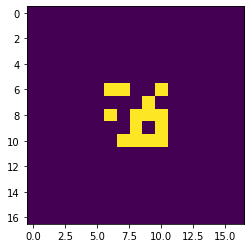

0.5452609388893618 0.5452609388893618


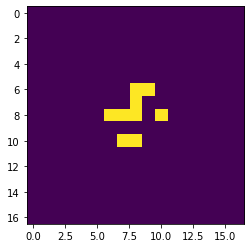

0.5452609388893618 0.5452609388893618


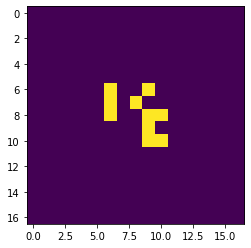

0.5452609388893618 0.5452609388893618


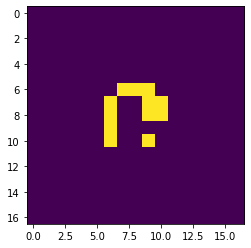

0.5452609388893618 0.5452609388893618


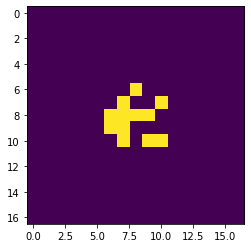

0.5452609388893618 0.5452609388893618


In [72]:
for coords, predmin, predmean in best_locals:
    mask = np.zeros((pattern_dim + 2*6, pattern_dim + 2*6))
    mask[coords[:,0] // 200, coords[:,1] // 200] = 1
    plt.imshow(mask)
    plt.show()
    print(predmin, predmean)

Sort according to the maximimum mean dipoles

In [73]:
localities_sorted = sorted(coords_predmin, key = lambda x: x[2], reverse = True)

In [74]:
best_locals = localities_sorted[:10]

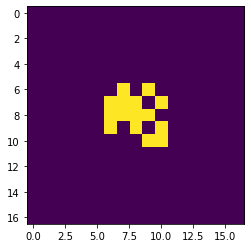

0.5452609388893618 0.5452609388893618


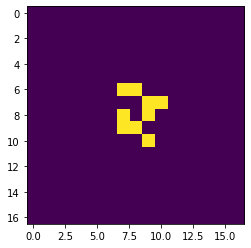

0.5452609388893618 0.5452609388893618


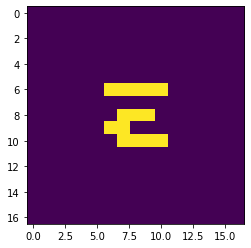

0.5452609388893618 0.5452609388893618


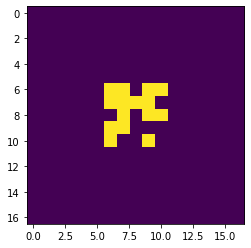

0.5452609388893618 0.5452609388893618


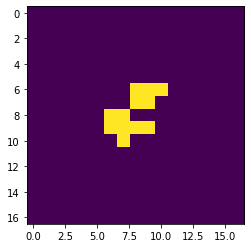

0.5452609388893618 0.5452609388893618


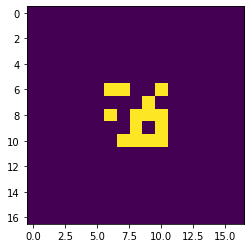

0.5452609388893618 0.5452609388893618


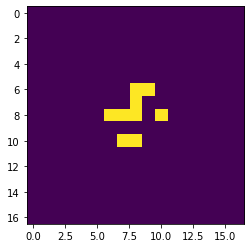

0.5452609388893618 0.5452609388893618


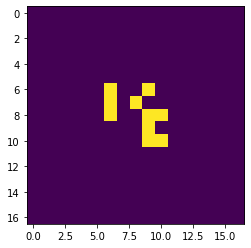

0.5452609388893618 0.5452609388893618


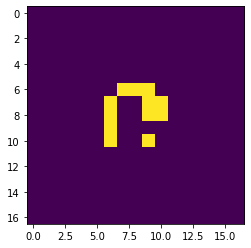

0.5452609388893618 0.5452609388893618


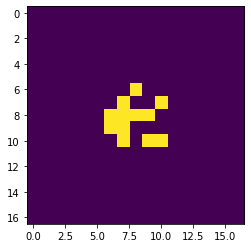

0.5452609388893618 0.5452609388893618


In [75]:
for coords, predmin, predmean in best_locals:
    mask = np.zeros((pattern_dim + 2*6, pattern_dim + 2*6))
    mask[coords[:,0] // 200, coords[:,1] // 200] = 1
    plt.imshow(mask)
    plt.show()
    print(predmin, predmean)

### check scores across windows of varying sizes

In [83]:
discriminator = rf_model(dfSub)

In [79]:
elite_stats = []
for pattern_dim in range(3,11):
    coords_preds = []
    for _ in tqdm(range(100)):
        xs, ys = generate_pattern(pattern_dim, 0.5)
        if len(xs) != 0:
            coords, feats = extract_features(xs, ys, pattern_dim, local_radius, scale)
            preds = discriminator.predict(feats[:, 1:])
            pattern_min = np.min(preds)
            pattern_mean = np.mean(preds)
            coords_preds.append((pattern_min, pattern_mean))

    localities_sorted = sorted(coords_preds, key = lambda x: x[0], reverse = True)
    elite_stats.append(np.mean(np.array(localities_sorted[:20]), axis = 0))

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 62.71it/s]


In [80]:
elite_stats

[array([0.2481174 , 0.25616254]),
 array([0.54020005, 0.55759669]),
 array([0.54933419, 0.56018267]),
 array([0.54394217, 0.55991312]),
 array([0.54581029, 0.56023492]),
 array([0.54440944, 0.56025548]),
 array([0.54154348, 0.55993428]),
 array([0.53813636, 0.56031159])]

Check differences across probabilities holding window size to 5x5

In [86]:
localities_sorted_windows = []
elite_stats = []
for prob in np.linspace(0.1,.9,12):
    coords_preds = []
    for _ in tqdm(range(100)):
        xs, ys = generate_pattern(5, prob)
        if len(xs) != 0:
            coords, feats = extract_features(xs, ys, 5, local_radius, scale)
            preds = discriminator.predict(feats[:, 1:])
            pattern_min = np.min(preds)
            pattern_mean = np.mean(preds)
            coords_preds.append((pattern_min, pattern_mean))

    localities_sorted = sorted(coords_preds, key = lambda x: x[0], reverse = True)
    localities_sorted_windows.append(localities_sorted)
    elite_stats.append(np.mean(np.array(localities_sorted[:20]), axis = 0))

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.97it/s]


array([0.1       , 0.21428571, 0.32857143, 0.44285714, 0.55714286,
       0.67142857, 0.78571429, 0.9       ])

Text(0, 0.5, 'Predicted Dipole')

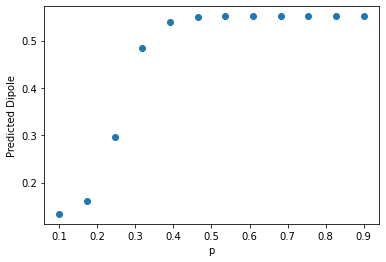

In [94]:
plt.scatter(np.linspace(0.1,.9,12), np.array(elite_stats)[:, 0])
plt.xlabel("p")
plt.ylabel("Predicted Dipole")

In [31]:
# generate fully one windows and predict

In [117]:
discriminator, scaler = get_discriminator(dfSub, 'linear')

In [118]:
arr5 = np.ones((5,5))
arr10 = np.ones((10,10))
arr20 = np.ones((20,20))
arr40 = np.ones((40,40))

In [119]:
arrs = [arr5, arr10, arr20, arr40]

In [120]:

pattern_dims = [5, 10 , 20, 40]
for i, arr in enumerate(arrs):
    xs, ys = np.nonzero(arr)
    coords, feats = extract_features(xs, ys, pattern_dims[i], local_radius, scale)
    preds = discriminator.predict(scaler.transform(feats[:, 1:]))
    print(np.mean(feats[:, 1:], axis=0))
    predMin = np.min(preds)
    predMean = np.mean(preds)
    print(predMin, predMean)
    
    

[7.38478936e+06 3.64242531e+03]
159213858938.51477 175896034498.2334
[1.37509871e+07 3.64241863e+03]
159213858938.51477 327552175620.88696
[1.75070437e+07 3.64241486e+03]
159213858938.51477 417029298882.1289
[1.95283115e+07 3.64241286e+03]
159213858938.51477 465180123687.72876


In [114]:
np.mean(dfSub.values, axis = 0)

array([1.13125122e-06, 6.03526334e+01, 1.30408502e-01])

In [131]:
xs, ys = np.nonzero(np.ones((5,5)))

In [132]:
xs, ys

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4]),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4]))

In [133]:
coords, feats = extract_features(xs, ys, 5, 1000, 200)

In [134]:
coords

array([[1200, 1200],
       [1200, 1400],
       [1200, 1600],
       [1200, 1800],
       [1200, 2000],
       [1400, 1200],
       [1400, 1400],
       [1400, 1600],
       [1400, 1800],
       [1400, 2000],
       [1600, 1200],
       [1600, 1400],
       [1600, 1600],
       [1600, 1800],
       [1600, 2000],
       [1800, 1200],
       [1800, 1400],
       [1800, 1600],
       [1800, 1800],
       [1800, 2000],
       [2000, 1200],
       [2000, 1400],
       [2000, 1600],
       [2000, 1800],
       [2000, 2000]])

In [135]:
feats

array([[6.79998875e+01, 6.68450761e+06, 3.64243121e+03],
       [6.79998453e+01, 7.32112738e+06, 3.64242700e+03],
       [6.79998364e+01, 7.63943727e+06, 3.64242605e+03],
       [6.79998453e+01, 7.32112738e+06, 3.64242700e+03],
       [6.79998875e+01, 6.68450761e+06, 3.64243121e+03],
       [6.79998453e+01, 7.32112738e+06, 3.64242700e+03],
       [6.79997936e+01, 7.63943727e+06, 3.64242159e+03],
       [6.79997834e+01, 7.63943727e+06, 3.64242048e+03],
       [6.79997936e+01, 7.63943727e+06, 3.64242159e+03],
       [6.79998453e+01, 7.32112738e+06, 3.64242700e+03],
       [6.79998364e+01, 7.63943727e+06, 3.64242605e+03],
       [6.79997834e+01, 7.63943727e+06, 3.64242048e+03],
       [6.79997725e+01, 7.63943727e+06, 3.64241928e+03],
       [6.79997834e+01, 7.63943727e+06, 3.64242048e+03],
       [6.79998364e+01, 7.63943727e+06, 3.64242605e+03],
       [6.79998453e+01, 7.32112738e+06, 3.64242700e+03],
       [6.79997936e+01, 7.63943727e+06, 3.64242159e+03],
       [6.79997834e+01, 7.63943

### simulated annealing algorithm

In [203]:
coords_best = best_locals[0][0]

In [204]:
coords_best //= 200

In [205]:
coords_best

array([[6, 6],
       [6, 7],
       [6, 8],
       [7, 6],
       [7, 8],
       [7, 9],
       [8, 6],
       [8, 8],
       [9, 6],
       [9, 7],
       [9, 8]])

In [206]:
mask = np.zeros((pattern_dim + 2*6, pattern_dim + 2*6))

In [208]:
mask[coords_best[:,0], coords_best[:,1]] = 1

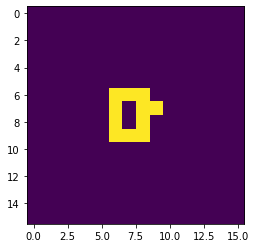

In [209]:
plt.imshow(mask)

In [283]:
# number of organoids
n = len(coords_best)
# pick one among them
choose_org = np.random.randint(n)

In [284]:
curr_coord = coords_best[choose_org]

In [285]:
y,x = curr_coord[0], curr_coord[1]

In [286]:
nbors = mask[x-1:x+2, y-1:y+2]

In [287]:
nbors

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 1.]])

In [288]:
zx, zy = np.where(nbors == 0)

In [289]:
n_zeros = len(zx)

In [290]:
zx_scaled, zy_scaled = zx+x-1, zy+y-1

In [292]:
mask[zx_scaled, zy_scaled]

array([0., 0., 0., 0., 0.])

In [294]:
choose_direction = np.random.randint(n_zeros)

In [296]:
choose_direction

4